In [1]:
from IPython.core.display import HTML
HTML("""<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>""");

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
from matplotlib.ticker import LinearLocator

In [6]:
from matplotlib import cm

In [7]:
import seaborn as sns

In [8]:
import functions as fct

In [9]:
from sklearn import linear_model

# Introduction et notations

La régression linéaire est une méthode d'approximation d'une grandeur continue par une fonction linéaire d'une ou de plusieurs variables. Ce Notebook a pour but d'expliquer le fonctionnement de cette méthode et le choix des paramètres.
Pour illustrer, nous utiliserons un jeu de données contenant les profits réalisé par des restaurants de la même chaîne dans différentes villes ainsi que la population de chacune de ces villes. Nous allons ainsi tenter de determiner une relation entre la grandeur continue correspondant au profit et la variable explicative population, à l'aide d'une régression simple.

Dans la suite, nous utiliserons les notations suivantes : <br/>
$y$ : la variable à expliquer <br/>
$\bar{y}$ : prediction de la grandeur y. <br/>
$X_{1},...,X_{n}$ : les variables explicatives. Dans le cas d'une regression simple (à une seule variable), on note la seule variable explicative X. <br/>
$m$ : le nombre d'échantillons. $\Rightarrow X_{i=1,...,n},y,\bar{y} \in \mathbb{R}^{m}$ <br/>

Les notations ayant été posées, il est maintenant possible de formuler le problème de la régression linéaire : <br/>
La régression linéaire consiste à approcher une grandeur continue $y$ par une grandeur prédite $\bar{y}$ définie par : $\bar{y}=\theta_{0}+\theta_{1}X_{1} + ... + \theta_{n}X_{n} = \theta^{T}X$ <br/>
Et dans le cas d'une régression simple : $\bar{y}=\theta_{0}+\theta_{1}X_1=\theta^{T}X$ avec $\theta = (\theta_0,~\theta_1)$

Pour pouvoir appliquer le calcul matriciel et vectorizer l'équation $\bar{y}=\theta_{0}+\theta_{1}X_{1} + ... + \theta_{n}X_{n}$, il est d'usage d'effectuer la transformation suivante : <br/>
<br/>
$X=\begin{pmatrix}1 & X_1^{(1)} & X_2^{(1)} & X_n^{(1)} \\\ 1 & X_1^{(2)} & X_2^{(2)} & X_n^{(2)}\\\ \vdots & \vdots & \vdots & \vdots \\\ 1 & X_1^{(m)} & X_2^{(m)} & X_n^{(m)}\end{pmatrix}$, avec $X_i=\begin{pmatrix}X_{i}^{(1)}\\\ X_{i}^{(2)} \\\ \vdots \\\ X_{i}^{(m)} \end{pmatrix}$ <br/>
<br/>
Dans le cas de la regression simple : <br/>
<br/>
$X=\begin{pmatrix}1 & X_1^{(1)}\\\ 1 & X_1^{(2)} \\\ \vdots & \vdots \\\ 1 & X_1^{(m)}\end{pmatrix}$ avec $X_1=\begin{pmatrix}X_1^{(1)}\\\ X_1^{(2)} \\\ \vdots \\\ X_1^{(m)} \end{pmatrix}$

# La Régression Simple

## Importation des données

Nous commençons par importer les données à l'aide de la librairie pandas. La première colonne contient les populations de chaque ville (variable explicative $X$) et la seconde contient le profit réalisé par le restaurant dans la ville correspondante (variable expliquée $y$).

In [10]:
data = pd.read_csv("data1.txt")

In [11]:
X1 = data["X1"].to_numpy() # population de chaque ville (en 10 000 ème d'habitants).

In [12]:
y = data["y"].to_numpy() # profit réalisé par chaque restaurant (en 10 000 ème de $).

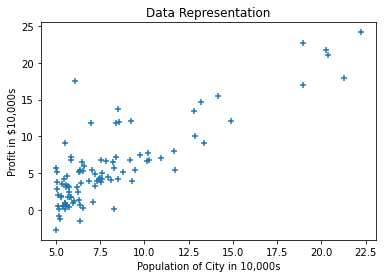

In [14]:
figure = plt.figure
plt.scatter(X1,y,marker="+")
plt.title("Data Representation")
plt.xlabel("Population of City in 10,000s");
plt.ylabel("Profit in $10,000s");

Dans la suite, nous allons tenter d'approcher ce graphique par une fonction linéaire en essayant de tracer une droite de façon à minimiser la distance entre chaque point du graphique et cette droite. Il est important de noter que contrairement à ce que son nom laisse suggérer, la régression linéaire ne résulte pas forcément en une droite. En réalité, la forme de la courbe obtenue dépend des variables explicatives choisies. Par exemple, si la variable explicative choisie est $X^{2}$ au lieu de $X$, la courbe obtenue sera une parabole au lieu d'être une droite. C'est pourquoi il est important de commencer par analyser la forme des donnée pour identifier le type de fonction le plus adéquat et en déduire les variables explicatives les plus adaptées.    

## Exploration des données

Avant de nous lancer dans la modélisation, nous commençons par faire un peu d'exploration de données pour bien comprendre les données avec lesquels ont va travailler et pour voir s'il faut procéder à un nettoyage des données.

<AxesSubplot:xlabel='X1'>

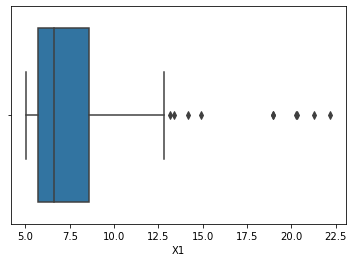

In [15]:
sns.boxplot(x="X1",data=data) # boxplot des populations.

Ce boxplot nous apprend qu'au moins 75% des restaurants de notre échantillon ont une population inférieure à 85800 habitants (villes moyennes). Elle montre aussi la présence de valeurs atypiques, à savoir les villes ayant une population de plus de 127000 habitants. (ici, atypique ne veux pas dire fausse, cela signifie simplement que les valeurs sont très grandes par rapport à la médiane)

Pour plus de lisibilité, nous allons diviser les villes en quatre classe en fonction de leur population $X1=P$ :<br/>
$P\in [50000,100000[$ (les petites villes) <br/> $P\in [100000,150000[$ (les villes moyennes) <br/> $P\in [150000,+\infty[$ (les grandes villes).

In [16]:
#Catégorisation de la variable continue population (X1).
data.insert(2,"population_range",pd.cut(data["X1"],bins=[5,10,15,22.5],labels=["50000<X1<100000","100000<X1<150000","X1>150000"]))

<AxesSubplot:xlabel='population_range', ylabel='y'>

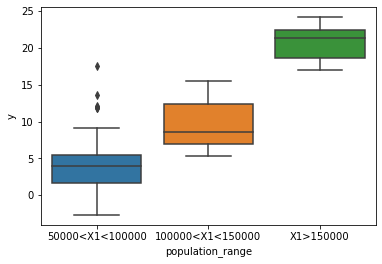

In [17]:
sns.boxplot(data=data,x="population_range",y="y") #Boxplot du profit en fonction de la classe de population.

La relation linéaire entre le profit et la population peut déjà s'intuiter en observant le boxplot. Pour la première classe de population, on observe trois outliers qui correspondent à des restaurants situés dans des villes peu peuplés mais ayant réalisé un profit aussi important que les villes moyennes. Ces restaurants sont, pour cette raison, dignes d'intérêt. 

La méthode describe() de pandas nous donne accès à des grandeurs statistiques intéressantes (les moments) de notre échantillons de donnée. 

In [18]:
data.describe()

,X1,y
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


Elle nous apprend par exemple que le profit moyen réalisé par les restaurants de l'échantillon vaut - 26 800 ${$}$. En moyenne, les restaurants ont un bénefice négatif, pourtant la somme de tout les bénéfices est positive puisqu'elle vaut 5 663 961 ${$}$. Cela signifie que les bénéfices engendré par les restaurants qui réalise de gros profits suffisent à compenser les pertes des plus petits restaurants. 

Dans la suite de ce notebook, nous allons tenter de modéliser le profit réaliser par chaque restaurant en cherchant une relation linéaire entre le profit et la population de la ville. 

Avant de se lancer dans une régression linéaire, il est bon de commencer par calculer le coefficient de correlation linéaire (aussi appelé coefficient de Pearson) entre les deux variables que l'on souhaite modéliser. <br/>
Le coefficient de correlation linéaire de deux variables $X=\left( X_1,X_2,...,X_m \right)$ et $Y=\left( Y_1,Y_2,...,Y_m \right)$ est définie par : $r_{X,Y}=\frac{\sum_{i=0}^{m}(X_i-\bar{X})(Y_i-\bar{Y})}{ \left( \sum_{i=0}^{m}(X_i-\bar{X})^2 \right)^{\frac{1}{2}} \left( \sum_{i=0}^{m}(X_i-\bar{X})^2\right)^{\frac{1}{2}}}  $ avec : $m$ : taille de l'échantillon et $\bar{X},\bar{Y}$ : moyenne de $X$, de $Y$.
On peut soit programmer la fonction soit même, soit utiliser la fonction built in


In [19]:
print("Le coefficient de Pearson de X1 (la population) et y (le profit) vaut :",np.corrcoef(X1,y)[0,1])

Le coefficient de Pearson de X1 (la population) et y (le profit) vaut : 0.8378732325263412


Le coefficient de Pearson est proche de 1. Il est donc raisonnable de penser qu'il y a une relation linéaire entre la population de chaque ville et le profit réalisé par le restaurant de cette ville. Ceci justifie le choix du modèle linéaire.

## Représentation du coût

Le coût est la grandeur que nous cherchons à minimiser pour que la courbe résultante de la régression s'adapte au mieux à nos données. Il est possible d'envisager plusieurs coûts : <br/>
$C_1(X,y,\theta)=\frac{1}{2m}\sum_{k=0}^{m}|\bar{y}-y|$ : Mean Absolute Error (MAE) $(1)$ <br/>
$C_2(X,y,\theta)=\frac{1}{2m}\sum_{k=0}^{m}(\bar{y}-y)^{2}$ : Mean Squared Error (MSE) $(2)$ <br/>
En général, la régression linéaire fait appel à la méthode des moindres carrés, ce qui revient à utiliser la formule $(2)$. <br/>

La détermination des paramètres $\theta_{i}$ de la courbe de régression équivaut donc à résoudre le problème suivant : <br/>
$\min_{\theta}~C_{2}(X,y,\theta)$ <br/>
Pour le résoudre, on utilise l'algorithme du gradient descendant qui nécessite trois paramètres pour fonctionner :<br/>
- Une valeur initiale de $\theta$.
- Le taux d'apprentissage $\alpha$.
- Le nombre d'itérations à réaliser.

Dans cette section, nous allons faire varier theta dans la plage suivante : $\theta_0 \in [-10,10]$ et $\theta_1 \in [-1,4]$ et pour chacune des valeurs de $(\theta_0,\theta_1)$, nous allons calculer $C_2(\theta)$ ($X$ et $y$ sont fixes).

In [20]:
m = y.shape[0] # Taille de l'échantillon
X = np.array([[1,round(X1[i],4)] for i in range(m)]) # On ajoute une colonne de 1 à la matrice X.

In [21]:
theta0_range = np.linspace(-10,10,100) # Vecteur des valeurs de theta_0.

In [22]:
theta1_range = np.linspace(-1,4,100) # Vecteur des valeurs de theta_1.

In [23]:
cost_computed = np.zeros((theta0_range.shape[0],theta1_range.shape[0]))
for i in range(theta0_range.shape[0]): 
    for j in range(theta1_range.shape[0]):
        theta=[theta0_range[i],theta1_range[j]]
        cost_computed[i,j]=fct.cost(X,y,theta) # Calcul des valeur du coût pour chaque valeur de theta_0 et theta_1

Puis nous représentons la fonction $C_2(\theta_0, \theta_1)$ à l'aide d'un graphique 3D.

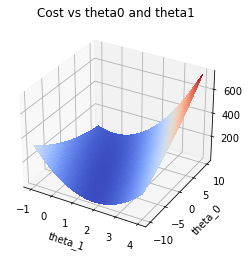

In [63]:
#Affichage de la fonction coût C2(theta_0,theta_1) :
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
theta1_range_msh, theta0_range_msh = np.meshgrid(theta1_range, theta0_range)
C = cost_computed

# Plot the surface.
surf = ax.plot_surface(theta1_range_msh, theta0_range_msh, cost_computed, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('Cost vs theta0 and theta1')
plt.xlabel('theta_1');
plt.ylabel('theta_0');
plt.show()

In [64]:
np.min(C) # Valeur minimale du coût

4.480459391893312

À l'aide de la méthode where du module numpy, nous déterminons le minimum de la matrice $C = cost\_computed$ qui contient les valeurs des $C_2(\theta_0,\theta_1)$

In [26]:
theta_init = [theta0_range[np.where(Z==np.min(Z))[0][0]],theta1_range[np.where(Z==np.min(Z))[1][0]]] 
theta_init # Valeur de theta correspondant au coût minimal

[-3.737373737373738, 1.1717171717171717]

Cette valeur de $theta\_init$ fait un bon candidat pour l'initialisation de l'algorithme du gradient descendant. Cependant, il peut s'agir d'un minimum local et le cas échéant, risque de produire une approximation peu précise. C'est pour cette raison qu'il faut parfois tester plusieurs valeurs de $theta\_init$ avant de tomber sur le bon optimum. Cela dit, cette méthode reste intéressante et peut offrir de bons résultats.

## Définition des paramètres du gradient descendant

Dans cette section, nous initialisons les paramètres du gradient descendant. Nous fixons $theta=theta\_init$ proche de la valeur obtenue dans la section précedente.

In [27]:
theta_init=np.array([-4,1]) # Initialisation de theta

In [28]:
alpha = 0.01 # Initialisation de alpha

Le paramètre alpha correspont au taux d'apprentissage du gradient descendant. Intuitivement, plus il est faible, plus le gradient se rapproche lentement de l'optimum. S'il est trop faible l'algorithme risque de nécessiter un grand nombre d'itérations avant de converger, voir de ne jamais converger. S'il est trop élevé, l'algorithme diverge car les pas de gradients sont trop grand. Il est donc important de bien le choisir. Pour ce faire la méthode la plus simple consiste à tester plusieurs valeurs de alpha et à traçer le coût en fonction du nombre d'iterations pour chacune de ces valeurs. On garde alors la valeur de alpha qui resulte en un coût minimal et atteint en un nombre d'iterations minimal.
Nous expliquerons ce choix de alpha dans la section dédiée.

In [29]:
n_iter = 10 # Choix du nombre d'itération

## Gradient descendant 

Dans cette section, nous utilisons la fonction $gradient\_descent$, que nous avons définie dans le module annexe functions.py et initialisé à l'aide des paramètres définis dans la section précédente. Cette dernière calcule la valeur de theta qui répond à notre problème. Puis nous comparons la courbe obtenue avec celle obtenue à l'aide de la librairie spécialisée scikit-learn. 

In [30]:
theta = fct.gradient_descent(X, y, theta_init, alpha, n_iter)[0]
theta # Calcul des paramètres de la régression à l'aide de notre fonction gradient.

array([-3.97825854,  1.20131941])

L'algorithme de la librairie spécialisée scikit-learn ne nécessite quant à lui aucune initialisation de paramètres, seules les vecteurs $X$ et $y$ sont recquis.

In [31]:
reg = linear_model.LinearRegression() # Définition du modèle de régression linéaire de la librairie scikit learn.

In [32]:
reg.fit(X1.reshape(-1,1),y) # Entraînement de notre modèle.

LinearRegression()

In [33]:
theta_skl = [reg.intercept_,reg.coef_[0]]
theta_skl # Valeurs des paramètres de la régression obtenu à l'aide de la librairie scikit-learn.

[-3.8957808783118537, 1.193033644189594]

In [34]:
y_predict = np.dot(X,theta) # Calcul des prédictions à l'aide de notre fonction de regression.

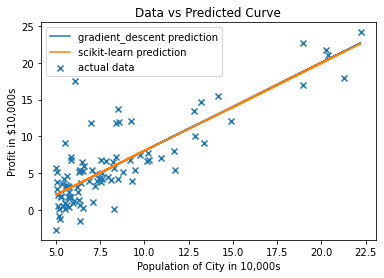

In [35]:
figure = plt.figure
plt.plot(X1,y_predict) # Courbe obtenue avec notre fonction de régression.
plt.plot(X1,theta_skl[1]*X1+theta_skl[0]) # Courbe de référence obtenue avec la librairie scikit learn.
plt.scatter(X1,y,marker="x") # Données initiales
plt.title("Data vs Predicted Curve")
plt.xlabel("Population of City in 10,000s");
plt.ylabel("Profit in $10,000s");
plt.legend(["gradient_descent prediction","scikit-learn prediction","actual data"])

La courbe obtenue à l'aide de notre gradient descendant et la courbe de référence obtenue par la librairie spécialisée scikit-learn sont presque superposables. De plus, elles décrivent bien la tendance observée sur les données réelles.

## Choix du taux d'apprentissage $ \alpha$

Afin de choisir le taux d'apprentissage $\alpha$, nous testons plusieurs valeurs de alpha et pour chacune d'elle, nous traçons les coûts en fonction du nombre d'itérations. 

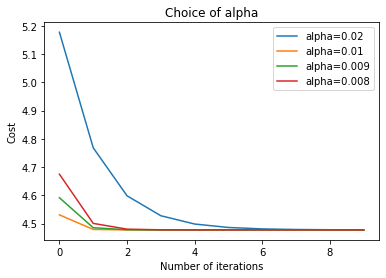

In [36]:
figure = plt.figure
alpha_values=[0.02,0.01,0.009,0.008] # Valeurs testées de alpha.
labels=["alpha="+str(x) for x in alpha_values] # Labels correspondant aux valeurs testées de alpha.
for alpha in alpha_values: #On itère sur les valeurs de alpha que l'on veut tester.
    theta_predict = fct.gradient_descent(X, y, theta_init, alpha, n_iter)[0] # Calcul des paramètres de la régression.
    y_predict = np.dot(X, theta_predict) # Calcul des prédictions.
    cost=fct.gradient_descent(X, y, theta_init, alpha, n_iter)[1] # Calcul de l'historique des coûts (au fil des itérations de gradient descendant)
    plt.plot(range(n_iter),cost) # Coût en fonction du nombre d'itération.
    plt.title("Choice of alpha") 
    plt.xlabel("Number of iterations");
    plt.ylabel("Cost");
plt.legend(labels)

La valeur $\alpha=0.1$ semble être un choix raisonnable. Elle offre un coût minimal en un nombre d'itération lui aussi minimal.

## Interprétation des résultats

# La régression multiple

Pour illustrer la régression multiple, nous allons utiliser un jeu de donnée comprenant des informations sur des biens immobilier, à savoir la surface de chaque bien, son nombre de pièce et son prix de vente. Le but est de définir un modèle capable de prédire le prix de vente d'une maison $y$ (variable expliquée) donnée à partir de la connaissance de sa surface $X1$ et de son nombre de pièce $X2$ (les variables explicatives). 

## Importation des données

Nous importons les données à l'aide de la librairie pandas.

In [37]:
data_multiple = pd.read_csv("data2.txt")
data_multiple.head()

,X1,X2,y
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [38]:
data_multiple.describe();

In [39]:
X1 = data_multiple["X1"].to_numpy() # surface du bien immobilier (en m2)

In [40]:
X2 = data_multiple["X2"].to_numpy() # nombre de pièces

In [41]:
y = data_multiple["y"].to_numpy() # prix du bien

## Exploration des données

Nous allons utiliser les boxplots pour avoir un aperçu de la dispersion des données autour de leurs grandeurs centrales.

In [42]:
I = np.append(np.append(np.where(X2==2),np.where(X2==3)),np.where(X2==4)) # les inices des maisons ayant 2 à 4 pièces.

Comme il n'y a qu'une seule maison avec une seule pièce et qu'une seule maison avec 5 pièces dans notre échantillon, il n'est pas intéressant de les représenter sur le boxplot.

|Maison|Surface|Nombre de pièces|Prix|
|:---|:---|:---|:---| 
|Maison 13|2000|5|699900|
|Maison 31|500|1|169900|

<AxesSubplot:xlabel='X2', ylabel='y'>

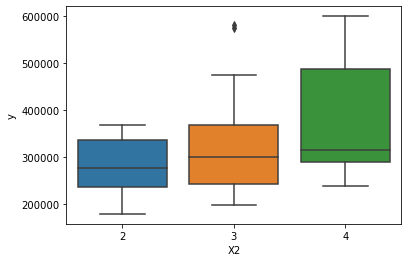

In [43]:
sns.boxplot(x=data_multiple["X2"].iloc[I],y=data_multiple["y"]) #boxplot du prix des maisons avec les échantillons de maisons ayant 2, 3 ou 4 pièces.

Text(0, 0.5, 'Prix (en $)')

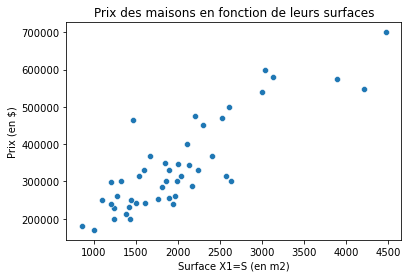

In [69]:
plt.figure()
sns.scatterplot(data=data_multiple,x="X1",y="y") # y correspond au prix et X1 à la surface de la maison (en m2)
plt.title("Prix des maisons en fonction de leurs surfaces")
plt.xlabel("Surface X1=S (en m2)")
plt.ylabel("Prix (en $)")

Nous allons diviser les maisons en 4 classes en fonction de leurs surface $X1=S$ : 
$S \in[0,1500[$, $S \in [1500,2500[$,$S \in [2500,3500[$ et $S \in [3500,4500]$,



In [45]:
categories = pd.cut(data_multiple.X1,bins=[0,1500,2500,3500,4500],labels=['0<S<1500','1500<S<2500','2500<S<3500','3500<S<4500'])

In [46]:
data_multiple.insert(3,'surface_range',categories)

Text(0.5, 0, 'Surface Range (en m2)')

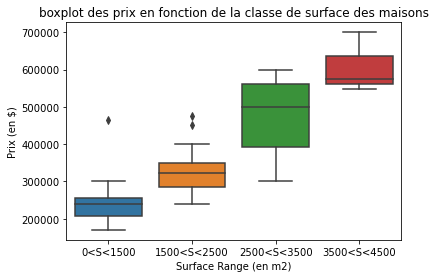

In [72]:
plt.figure()
sns.boxplot(x=data_multiple["surface_range"],y=data_multiple["y"])
plt.title("boxplot des prix en fonction de la classe de surface des maisons")
plt.ylabel("Prix (en $)")
plt.xlabel("Surface Range (en m2)")

Ce boxplot nous donne un aperçu de la répartitions des prix des maisons selon la classe de surface à laquelle elles appartiennent.

## Normalisation des variables (Feature scaling)

Dans le cas d'une régression multiple, le gradient descendant est appliqué à plusieurs variables explicatives. Pour qu'il puisse fonctionner correctement, il est important que les variables soit à la même échelle. Pour cette raison, nous les normalisons.<br/>
Pour cela, nous réalisons l'opération suivante :<br/>
<br/>
$X_{i,nmz}=\frac{X_i-mean(X_i)}{max(X_i)-min(X_i)}$ pour $i \in {1,...,n}$ ou $X_{i,nmz}=\frac{X_i-mean(X_i)}{std(X_i)}$ pour $i \in {1,...,n}$ <br/>
<br/>
Ainsi, nous aurons $-1 \leq X_i \leq 1$ pour $i \in {1,...,n}$ <br/>
    L'équation de la régression devient alors : $y=\theta_{0, nmz}+\theta_{1, nmz}X_{1,nmz}+...+\theta_{n, nmz}X_{n,nmz}$

In [48]:
X1_normalized = (X1-np.mean(X1))/(np.max(X1)-np.min(X1)) # vecteur des surfaces normalisées

In [49]:
X2_normalized = (X2-np.mean(X2))/(np.max(X2)-np.min(X2)) # vecteur des nombres de pièces normalisées

In [50]:
m = y.shape[0] # taille de l'échantillon
X = np.array([[1, X1[i], X2[i]] for i in range(m)]) # On ajoute une colonne de 1 à la matrice X
X_nmz = np.array([[1, X1_normalized[i], X2_normalized[i]] for i in range(m)]) # Colonne des valeurs normalisées de la matrice X

In [51]:
# Création d'un dataframe contenant les variables normalisées.
normalized_data = pd.DataFrame([[X1_normalized[i],X2_normalized[i],y[i]] for i in range(m)],columns=["X1","X2","y"]) 
normalized_data.head()

,X1,X2,y
0,0.028494,-0.042553,399900
1,-0.110502,-0.042553,329900
2,0.110127,-0.042553,369000
3,-0.161247,-0.292553,232000
4,0.275598,0.207447,539900


## Définition des paramètres du gradient descendant

In [52]:
theta_init = np.array([0,0,0]) # Initialisation des paramètres de la régression

In [53]:
alpha = 1 # Initialisation de alpha

In [73]:
n_iter = 400 # Choix du nombre d'itération

## Gradient descendant 

In [55]:
theta_nmz = fct.gradient_descent_multiple(X_nmz, y, theta_init, alpha, n_iter)[0] # On applique le gradient descendant avec les variables normalisées.
theta_nmz 

array([340412.65957447, 504610.29953345, -34736.6665571 ])

Comme nous avions normalisé nos variables, il faut recalculer les paramètres $\theta_i$ pour repasser en variables non normalisées. Pour cela on utilise les formules suivantes :<br/>
$\theta_0 = \theta_{0,nmz}-\sum_{i=1}^{n}{\frac{\theta_{i,nmz}~ * ~mean(X_i)}{max(X_i)-min(X_i)}}$ et $\theta_{i}=\frac{\theta_{i,nmz}}{max(X_i)-min(X_i)}$ pour $i \in {1,...,n}$


In [56]:
theta=fct.reverse_normalization(theta_nmz,X) # Cette fonction recalcule les theta_i en tenant compte cette fois de la normalisation des variables.
theta

array([89519.66313703,   139.16445106, -8684.16663927])

Les prédictions se calcule grâce à la formule : <br/>
$\bar{y}=\theta^{T}X$

In [57]:
reg_multiple = linear_model.LinearRegression() # Définission du modèle à l'aide de la librairie scikit-learn.

In [58]:
reg_multiple.fit(np.array([[X1[i],X2[i]] for i in range(m)]),y) # Entrainement du modèle

LinearRegression()

In [59]:
theta_skl = [reg_multiple.intercept_,reg_multiple.coef_[0],reg_multiple.coef_[1]] # Paramètres de la régression obtenus à l'aide de la librairie scikit-learn.
theta_skl

[89597.90954279754, 139.2106740176255, -8738.019112327827]

Les valeurs des paramètres $\theta_i$ obtenue avec le gradient descendant que nous avons implémenté et celles obtenues avec la librairie scikit-learn sont relativement proche.

## Calcul du coût et choix de alpha

Comme pour la régression simple on peut choisir le taux d'apprentissage $\alpha$ en représentant le coût pour plusieurs valeurs de alpha et en choisissant la valeur correspondant à un coût minimal, atteint en un nombre minimal d'itérations. 

In [60]:
cost_values = fct.gradient_descent_multiple(X_nmz, y, theta_init, alpha, n_iter)[1] # Calcul de l'historique des coûts.

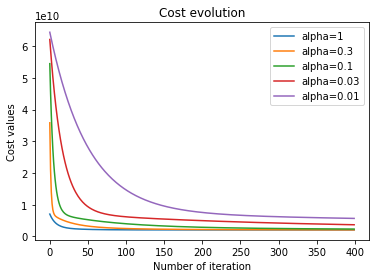

In [75]:
figure = plt.figure
alpha_values = [1,0.3,0.1,0.03, 0.01] # Valeurs testées de alpha
labels=["alpha="+str(x) for x in alpha_values] # Labels correspondant aux valeurs testées de alpha.
for alpha in alpha_values: # On itère sur les valeurs de alpha que l'on veut tester.
    cost_values = fct.gradient_descent_multiple(X_nmz, y, theta_init, alpha, n_iter)[1] #Calcul de l'historique des coûts pour la valeur courante de alpha
    plt.plot(range(n_iter),cost_values) #Affichage du coût en fonction du nombre d'itération.
plt.legend(labels);
plt.title("Cost evolution");
plt.xlabel("Number of iteration");
plt.ylabel("Cost values");

La valeur $\alpha=1$ semble être un bon candidat.

## Interprétation des résultats

Nous avons détérminer les coefficients du modèle qui fournit le prix d'une maison en fonction de sa surface et du nombre de pièces : $prix = \theta_0 ~ +\theta_1 ~ * ~ surface + \theta_2 ~ * ~ nombre ~ de ~ pièces$ <br/>
Nous pouvons maintenant nous en servir sur des données qui n'appartienne pas à notre échantillons pour effectuer des prédictions.<br/>
Exemple :<br/>

|Maison|Surface (en m2)|Nombre de pièces|Prix (en dollars)|
|:---|:---|:---|:---| 
|Maison 1|2000|5|?|
|Maison 2|500|2|?|
|Maison 3|1900|3|?|
|Maison 4|?|5|300000|
|Maison 5|1500|?|250000|

Les points d'interrogations sont les valeurs que nous souhaitons prédire.

In [62]:
prix1 = np.dot([1,2000,5],theta_skl) # prédiction du prix de la maison 1
prix2 = np.dot([1,500,2],theta_skl) # prédiction du prix de la maison 2
prix3 = np.dot([1,1900,3],theta_skl) # prédiction du prix de la maison 3
surface4 = (300000 - theta_skl[0]-theta_skl[2]*5)/theta_skl[1] #prédiction de la surface de la maison 4
n_piece5 = (250000 - theta_skl[0]-theta_skl[1]*1500)/theta_skl[2] #prédiction de la surface de la maison 4

En utilisant les paramètres calculés dans la section précédente, nous obtenons :<br/>

|Maison|Surface (m2)|Nombre de pièces|Prix (en dollars)|
|:---|:---|:---|:---| 
|Maison 1|2000|5|<span style="color:blue">324329</span>|
|Maison 2|500|2|<span style="color:blue">141727</span>|
|Maison 3|1900|3|<span style="color:blue">327884</span>|
|Maison 4|<span style="color:blue">1825</span>|5|300000|
|Maison 5|1500|<span style="color:blue">5</span>|400000|